In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
from matplotlib import rc
import scipy.integrate as integrate
from scipy.special import factorial
from tqdm import tqdm
import emcee
import corner

In [2]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [3]:
# Likelihood function
def Likelihood(n,b,s,mu):

    lambda_ = mu*s + b

    try:
        L = np.exp( -lambda_ )*lambda_**n / factorial(n)
    except OverflowError: 
        L = 1.

    return L

In [4]:
# Log Prior
def LogPrior(p):

    mu = p 

    if np.isscalar(mu):
        return 0. if mu >= 0. else -np.inf
    else:
        return 0. if np.any(mu >= 0.) else -np.inf
    

In [5]:
def GetJointLogLikelihood(mu,channels):

    n = channels[:,0]
    b = channels[:,1]
    s = channels[:,2]

    N = channels.shape[0]

    # log-likelihood contribution
    Joint = 0.

    for c in range(N):
        Joint += np.log(Likelihood( n[c], b[c], s[c], mu ))

    return Joint 

In [6]:
def LogPosterior(p,channels):
    return GetJointLogLikelihood(p,channels) + LogPrior(p)

In [7]:
n = np.array([0.])
b = np.array([0.])
s = np.array([1.])

channels = np.zeros((n.shape[0],3))
channels[:,0] = n
channels[:,1] = b
channels[:,2] = s

In [8]:
channels

array([[0., 0., 1.]])

In [9]:
GetJointLogLikelihood(1.3,channels)

-1.3

In [10]:
LogPosterior(1.3,channels)

-1.3

In [11]:
mu = np.linspace(0.,3.,100)
Posterior = LogPosterior(mu,channels)

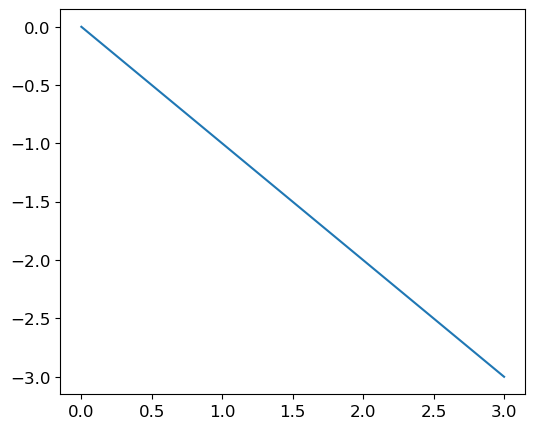

In [12]:
plt.plot(mu,Posterior)

# Algoritmo de metropolis

In [13]:
# Algoritmo de metropolis
n_walkers, n_params = 10,1
p0 = np.zeros((n_walkers,n_params))
p0[:,0] = 1.6
p0 += np.random.rand(n_walkers,n_params)
#p0

In [14]:
nll = lambda *p: LogPosterior(*p)
nll(0.9,channels)

-0.9

In [15]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, nll, args=[channels])
pos,prob,state = sampler.run_mcmc(p0, 10000, progress = True)

100%|█████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1866.01it/s]


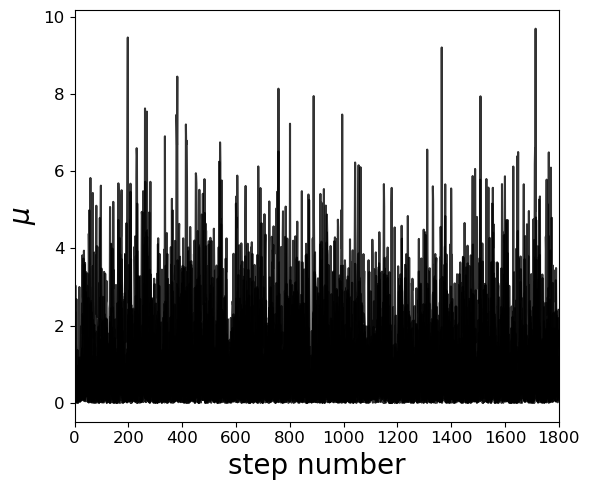

In [16]:
fig, axes = plt.subplots(n_params, sharex=True)

samples = sampler.get_chain(discard=1000, thin=5)
labels = [r"$\mu$"]

for i in range(n_params):

    axes.plot(samples[:,:,i],"k", alpha=0.8)
    axes.set_xlim(0, len(samples))
    axes.set_xlabel('step number')
    axes.set_ylabel(labels[i])

# Ajustar los márgenes automáticamente
plt.tight_layout()
plt.savefig('MCMC_1Channel.pdf')

In [17]:
flat_samples = sampler.get_chain(discard=1000, thin=5, flat=True)
truths = np.percentile(flat_samples, 50, axis=0)
truths

array([0.70040205])

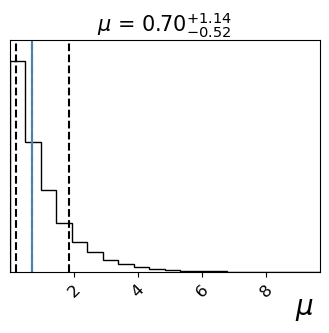

In [18]:
figure = corner.corner(flat_samples, 
                       truths=truths, 
                       labels=labels, 
                       quantiles=[0.16,0.5,0.84], 
                       show_titles=True,
                       title_kwargs={"fontsize":15})

axes = figure.axes

for ax in axes:
    ax.xaxis.set_label_coords(0.95,-0.1)

# Ajustar los márgenes automáticamente
plt.tight_layout()
plt.savefig('SamplingPosterior1Channel.pdf')

In [19]:
truths = np.percentile(flat_samples, 95, axis=0)
truths

array([3.01286543])

In [20]:
flat_samples

array([[1.25872527],
       [0.12669729],
       [1.33203419],
       ...,
       [0.65855769],
       [0.88308112],
       [2.45133508]])